# Descrição do projeto

Você trabalha em uma startup que vende produtos alimentícios. Você precisa analisar o comportamento do usuário para o aplicativo da empresa. Os designers gostariam de alterar as fontes de todo o aplicativo, mas os gerentes temem que os usuários achem o novo design intimidador. Eles decidem tomar a decisão com base nos resultados de um teste A/A/B. Descubra qual conjunto de fontes produz melhores resultados.

In [1]:
#importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st 
import numpy as np 
import math as mth 

## Abrir o arquivo

In [2]:
#ler o arquivo
df = pd.read_csv('/datasets/logs_exp_us.csv', sep = '\t')
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
                      EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- O conjunto de dados foi carregado corretamente usando o separador `\t`
- O import das bibliotecas foi feito de forma correta e em uma célula separada
</div>

## Preparar os dados

In [3]:
#renomear as colunas
df.columns = ['event_name', 'user_id', 'event_ts', 'group']

In [4]:
#corrigir os tipos de dados
df['group'] = df['group'].astype('category')
df['event_name'] = df['event_name'].astype('category')

#adicionar colunas de data e hora
df['event_datetime'] = pd.to_datetime(df['event_ts'], unit='s')
df['event_date'] = df['event_datetime'].dt.date
df['event_date'] = pd.to_datetime(df['event_date'])

print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      244126 non-null  category      
 1   user_id         244126 non-null  int64         
 2   event_ts        244126 non-null  int64         
 3   group           244126 non-null  category      
 4   event_datetime  244126 non-null  datetime64[ns]
 5   event_date      244126 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(2)
memory usage: 7.9 MB
None
                event_name              user_id    event_ts group  \
0         MainScreenAppear  4575588528974610257  1564029816   246   
1         MainScreenAppear  7416695313311560658  1564053102   246   
2  PaymentScreenSuccessful  3518123091307005509  1564054127   248   
3         CartScreenAppear  3518123091307005509  1564054127   248   
4  PaymentScreenSuccessful  621780765309499599

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- Os nomes das colunas foram convertidos para seguir o padrão `snake_case`
- A hora foi extraída a partir do timestamp
</div>

## Estudar e verificar os dados

- Quantos eventos ficam nos registros?

In [5]:
print(f"Total de eventos nos registros: {df.shape[0]}")

Total de eventos nos registros: 244126


- Quantos usuários ficam nos registros?

In [6]:
print(f"Total de usuários nos registros: {df['user_id'].nunique()}")

Total de usuários nos registros: 7551


- Qual é o número médio de eventos por usuário?

In [7]:
events_per_user = df.shape[0] / df['user_id'].nunique()
print(f"Número médio de eventos por usuário: {events_per_user:.2f}")

Número médio de eventos por usuário: 32.33


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
  
As estatísticas dos usuários foram analisadas
</div>

- Qual é o período de tempo que os dados cobrem?

In [8]:
min_date = df['event_datetime'].min()
max_date = df['event_datetime'].max()

print(f"Período coberto pelos dados: de {min_date} até {max_date}")

Período coberto pelos dados: de 2019-07-25 04:43:36 até 2019-08-07 21:15:17


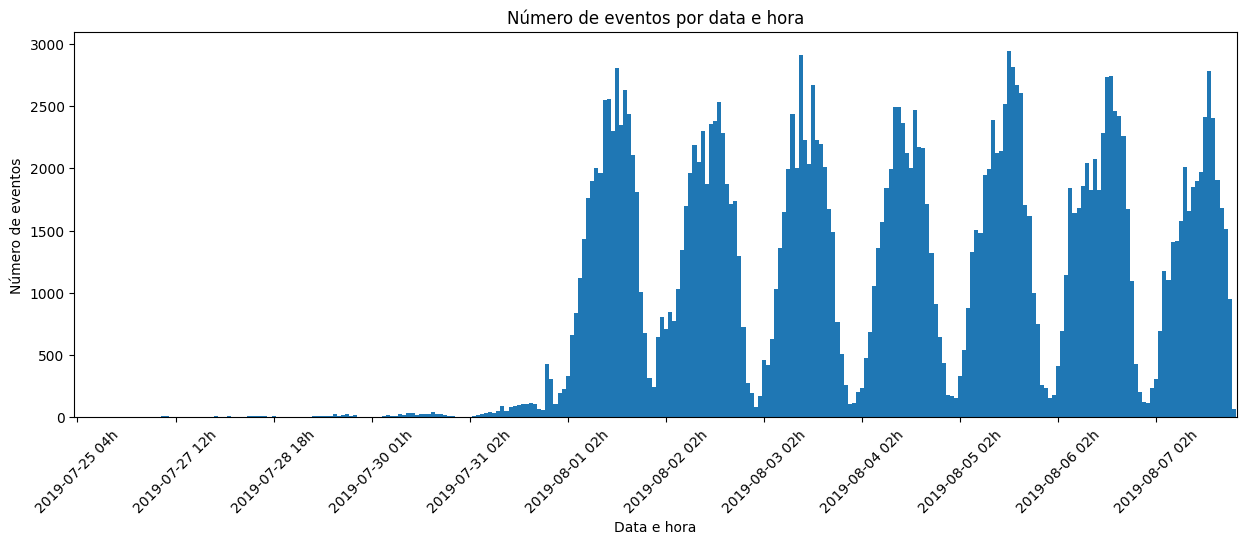

In [9]:
# Conta o número de eventos por hora
events_per_hour = df['event_datetime'].dt.floor('H').value_counts().sort_index()

#preparar o grafico
plt.figure(figsize=(15, 5))
events_per_hour.plot(kind='bar', width=1)

# Deixa só um rótulo a cada 24 horas
step = 24
xticks = range(0, len(events_per_hour), step)
xticklabels = [events_per_hour.index[i].strftime('%Y-%m-%d %Hh') for i in xticks]

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)
plt.title('Número de eventos por data e hora')
plt.xlabel('Data e hora')
plt.ylabel('Número de eventos')

plt.show()

<div class="alert alert-block alert-warning">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
  
O número de eventos ao longo dos dias foi analisado. Como sugestão, aqui você poderia agrupar por dia também e plotar um gráfico de barras ou linhas.
</div>

In [10]:
# Define a data de corte
start_date = pd.to_datetime('2019-08-01 00:00:00')

# Filtra o DataFrame
df_ = df[df['event_datetime'] >= start_date].copy()

min_date_ = df_['event_datetime'].min()
max_date_ = df_['event_datetime'].max()

print(f"Período realmente coberto pelos dados: de {min_date_} até {max_date_}")

Período realmente coberto pelos dados: de 2019-08-01 00:07:28 até 2019-08-07 21:15:17


- Você perdeu muitos eventos e usuários ao excluir os dados mais antigos?

In [11]:
# Tamanho do dataframe original (antes do filtro)
total_events_before = len(df)
total_users_before = df['user_id'].nunique()

# Tamanho do dataframe após o filtro
total_events_after = len(df_)
total_users_after = df_['user_id'].nunique()

# Percentual de perda
event_loss_pct = 100 * (total_events_before - total_events_after) / total_events_before
user_loss_pct = 100 * (total_users_before - total_users_after) / total_users_before

print(f"Eventos antes do corte: {total_events_before}")
print(f"Eventos depois do corte: {total_events_after}")
print(f"Perda de eventos: {event_loss_pct:.2f}%\n")

print(f"Usuários antes do corte: {total_users_before}")
print(f"Usuários depois do corte: {total_users_after}")
print(f"Perda de usuários: {user_loss_pct:.2f}%")


Eventos antes do corte: 244126
Eventos depois do corte: 241298
Perda de eventos: 1.16%

Usuários antes do corte: 7551
Usuários depois do corte: 7534
Perda de usuários: 0.23%


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
  
O percentual de perda de eventos/usuários após o filtro foi calculado.
</div>

- Certifique-se de ter usuários de todos os três grupos experimentais.

In [12]:
print("Número de usuários por grupo experimental:")
print(df_.groupby('group')['user_id'].nunique())

Número de usuários por grupo experimental:
group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


## Estudar o funil de eventos

- Quais eventos estão nos diários e sua frequência de ocorrência

In [13]:
# Frequência absoluta dos eventos
event_counts = df_['event_name'].value_counts()

# Frequência relativa (percentual)
event_percentages = df_['event_name'].value_counts(normalize=True) * 100

# Juntando as duas informações em um único DataFrame
event_stats = pd.DataFrame({
    'Frequência absoluta': event_counts,
    'Frequência relativa (%)': event_percentages.round(2)
})

# Exibindo os eventos ordenados por frequência
print("Eventos por frequência (ordenados):")
print(event_stats)

Eventos por frequência (ordenados):
                         Frequência absoluta  Frequência relativa (%)
MainScreenAppear                      117431                    48.67
OffersScreenAppear                     46350                    19.21
CartScreenAppear                       42365                    17.56
PaymentScreenSuccessful                34113                    14.14
Tutorial                                1039                     0.43


- Número de usuários que executaram cada uma dessas ações

In [14]:
# Total de usuários únicos no conjunto de dados
total_users = df_['user_id'].nunique()

# Número de usuários únicos que executaram cada evento pelo menos uma vez
users_per_event = df_.groupby('event_name')['user_id'].nunique()

# Proporção de usuários que realizaram cada evento
users_per_event_pct = (users_per_event / total_users) * 100

# Juntando em um DataFrame
event_user_stats = pd.DataFrame({
    'users_cnt': users_per_event,
    'users_cnt_pct': users_per_event_pct.round(2)
}).sort_values(by='users_cnt', ascending=False)

# Exibindo o resultado
print("Número e proporção de usuários por evento:")
print(event_user_stats)

Número e proporção de usuários por evento:
                         users_cnt  users_cnt_pct
event_name                                       
MainScreenAppear              7419          98.47
OffersScreenAppear            4593          60.96
CartScreenAppear              3734          49.56
PaymentScreenSuccessful       3539          46.97
Tutorial                       840          11.15


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- A proporção de usuários por etapa do funil foi analisada
- A ordem das etapas foi calculada!
</div>

- Parcela de usuários por etapa

In [15]:
# Etapas do funil
funnel_events = ['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Usuários únicos por evento
users_per_step = {
    event: set(df_[df_['event_name'] == event]['user_id'])
    for event in funnel_events
}

# Tamanho das bases de usuários em cada etapa
n_users = {event: len(users_per_step[event]) for event in funnel_events}

# Taxas de conversão entre etapas
conversion_1 = n_users['CartScreenAppear'] / n_users['MainScreenAppear']
conversion_2 = n_users['PaymentScreenSuccessful'] / n_users['CartScreenAppear']

# Exibindo os resultados
print(f"Usuários por etapa:")
for event in funnel_events:
    print(f" - {event}: {n_users[event]} usuários")

print("\nTaxas de conversão entre etapas:")
print(f" - MainScreen → CartScreen: {conversion_1:.2%}")
print(f" - CartScreen → PaymentSuccessful: {conversion_2:.2%}")

Usuários por etapa:
 - MainScreenAppear: 7419 usuários
 - CartScreenAppear: 3734 usuários
 - PaymentScreenSuccessful: 3539 usuários

Taxas de conversão entre etapas:
 - MainScreen → CartScreen: 50.33%
 - CartScreen → PaymentSuccessful: 94.78%


    A maior queda acontece logo após a tela principal, indicando que muitos usuários não avançam para o carrinho.

- Parcela de usuários que faz o caminho inteiro

In [16]:
complete_funnel_pct = n_users['PaymentScreenSuccessful'] / n_users['MainScreenAppear']
print(f"Parcela de usuários que completam o funil: {complete_funnel_pct:.2%}")

Parcela de usuários que completam o funil: 47.70%


<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>
    
- O percentual de usuários que percorrem todo o caminho foi calculado
- A perda de usuários foi calculada por etapa do funil
- O número de usuários por grupo foi analisado
</div>

## Estudar os resultados do experimento

### Quantos usuários há em cada grupo?

In [17]:
print("Número de usuários por grupo experimental:")
print(df_.groupby('group')['user_id'].nunique())

Número de usuários por grupo experimental:
group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


### Teste estatístico nos grupos de controle (A/A)

In [49]:
# Total de usuários por grupo
total_users = df_[df_['group'].isin([246, 247])].groupby('group')['user_id'].nunique()
trials = total_users.loc[[246, 247]].values

# Usuários que converteram por grupo
payment_users = df_[(df_['group'].isin([246, 247])) & 
                    (df_['event_name'] == 'PaymentScreenSuccessful')].groupby('group')['user_id'].nunique()
successes = payment_users.loc[[246, 247]].values

In [50]:
alpha = .05  # nível de significância

# proporções
p1 = successes[0] / trials[0]
p2 = successes[1] / trials[1]

# proporção combinada
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# diferença entre as proporções
difference = p1 - p2

# valor z
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# distribuição normal padrão
distr = st.norm(0, 1)

# p-valor
p_value = (1 - distr.cdf(abs(z_value))) * 2

# resultado
print('p-value:', p_value)
if p_value < alpha:
    print("Rejeitando a hipótese nula: há uma diferença significativa entre as proporções")
else:
    print("Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes")

p-value: 0.11456679313141849
Falha ao rejeitar a hipótese nula: não há motivo para considerar as proporções diferentes


### Teste estatístico para cada evento nos grupos de controle

In [75]:
#função para fazer o teste de diferença estatística
def test_proportions(event, group1, group2, df, alpha=0.05):
    # Total de usuários por grupo
    total_users = df[df['group'].isin([group1, group2])].groupby('group')['user_id'].nunique()

    # Usuários que fizeram o evento
    event_users = df[(df['group'].isin([group1, group2])) &
                     (df['event_name'] == event)].groupby('group')['user_id'].nunique()

    successes = event_users.loc[[group1, group2]].values
    trials = total_users.loc[[group1, group2]].values

    # proporções
    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2

    # z-value
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # distribuição normal padrão
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f"Evento: {event}")
    print(f"p-value: {p_value:.5f}")

    if p_value < alpha:
        print("Diferença significativa entre os grupos!")
    else:
        print("Grupos semelhantes nesse evento.")

#fazer o teste para cada evento entre os grupos A/A
for event in df_['event_name'].unique():
    test_proportions(event, 246, 247, df_)
    print()

Evento: Tutorial
p-value: 0.93770
Grupos semelhantes nesse evento.

Evento: MainScreenAppear
p-value: 0.75706
Grupos semelhantes nesse evento.

Evento: OffersScreenAppear
p-value: 0.24810
Grupos semelhantes nesse evento.

Evento: CartScreenAppear
p-value: 0.22883
Grupos semelhantes nesse evento.

Evento: PaymentScreenSuccessful
p-value: 0.11457
Grupos semelhantes nesse evento.



- O experimento está bem balanceado. Os testes A/A (controle 246 vs. 247) confirmaram que os grupos de controle são equivalentes estatisticamente.

### Teste estatístico A/B

In [57]:
#fazer o teste para cada evento entre os grupos A/B
for event in df_['event_name'].unique():
    print(f"Comparando grupo 248 com grupo 246 para o evento: {event}")
    test_proportions(event, 246, 248, df_)

    print(f"Comparando grupo 248 com grupo 247 para o evento: {event}")
    test_proportions(event, 247, 248, df_)

    print()

Comparando grupo 248 com grupo 246 para o evento: Tutorial
Evento: Tutorial
p-value: 0.82643
Grupos semelhantes nesse evento.
Comparando grupo 248 com grupo 247 para o evento: Tutorial
Evento: Tutorial
p-value: 0.76532
Grupos semelhantes nesse evento.

Comparando grupo 248 com grupo 246 para o evento: MainScreenAppear
Evento: MainScreenAppear
p-value: 0.29497
Grupos semelhantes nesse evento.
Comparando grupo 248 com grupo 247 para o evento: MainScreenAppear
Evento: MainScreenAppear
p-value: 0.45871
Grupos semelhantes nesse evento.

Comparando grupo 248 com grupo 246 para o evento: OffersScreenAppear
Evento: OffersScreenAppear
p-value: 0.20836
Grupos semelhantes nesse evento.
Comparando grupo 248 com grupo 247 para o evento: OffersScreenAppear
Evento: OffersScreenAppear
p-value: 0.91978
Grupos semelhantes nesse evento.

Comparando grupo 248 com grupo 246 para o evento: CartScreenAppear
Evento: CartScreenAppear
p-value: 0.07843
Grupos semelhantes nesse evento.
Comparando grupo 248 com gr

In [73]:
#função para fazer o teste A/B com os grupos controle combinados
def test_combined_control(event, df, alpha=0.05):
    # Considera apenas o evento de interesse
    df_event = df[df['event_name'] == event].copy()

    # Marca o tipo de grupo
    df_event['group_type'] = df_event['group'].replace({246: 'control', 247: 'control', 248: 'experiment'})

    # Contar quantos usuários únicos realizaram o evento em cada tipo de grupo
    df_event_unique = df_event[['user_id', 'group_type']].drop_duplicates()
    event_counts = df_event_unique['group_type'].value_counts()

    # Contar total de usuários para cada tipo de grupo
    total_users = df[['user_id', 'group']].drop_duplicates()
    total_users['group_type'] = total_users['group'].replace({246: 'control', 247: 'control', 248: 'experiment'})
    total_counts = total_users['group_type'].value_counts()

    successes = np.array([event_counts.get('experiment', 0), event_counts.get('control', 0)])
    trials = np.array([total_counts.get('experiment', 0), total_counts.get('control', 0)])

    p1 = successes[0] / trials[0]
    p2 = successes[1] / trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2
    denominator = mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    z_value = difference / denominator
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print(f"Evento: {event}")
    print(f"Usuários no grupo EXPERIMENTAL: {successes[0]}/{trials[0]} ({p1:.2%})")
    print(f"Usuários nos CONTROLES combinados: {successes[1]}/{trials[1]} ({p2:.2%})")
    print(f"p-value: {p_value:.5f}")

    if p_value < alpha:
        print("Diferença significativa entre os grupos!")
    else:
        print("Grupos semelhantes nesse evento.")
    print()

#fazer o teste para cada evento
for event in df_['event_name'].unique():
    test_combined_control(event, df_)


Evento: Tutorial
Usuários no grupo EXPERIMENTAL: 279/2537 (11.00%)
Usuários nos CONTROLES combinados: 561/4997 (11.23%)
p-value: 0.76486
Grupos semelhantes nesse evento.

Evento: MainScreenAppear
Usuários no grupo EXPERIMENTAL: 2493/2537 (98.27%)
Usuários nos CONTROLES combinados: 4926/4997 (98.58%)
p-value: 0.29425
Grupos semelhantes nesse evento.

Evento: OffersScreenAppear
Usuários no grupo EXPERIMENTAL: 1531/2537 (60.35%)
Usuários nos CONTROLES combinados: 3062/4997 (61.28%)
p-value: 0.43426
Grupos semelhantes nesse evento.

Evento: CartScreenAppear
Usuários no grupo EXPERIMENTAL: 1230/2537 (48.48%)
Usuários nos CONTROLES combinados: 2504/4997 (50.11%)
p-value: 0.18176
Grupos semelhantes nesse evento.

Evento: PaymentScreenSuccessful
Usuários no grupo EXPERIMENTAL: 1181/2537 (46.55%)
Usuários nos CONTROLES combinados: 2358/4997 (47.19%)
p-value: 0.60043
Grupos semelhantes nesse evento.



#### Conclusão
    A alteração testada (nova fonte no grupo 248) não teve impacto mensurável. Nenhum dos eventos analisados (como MainScreenAppear, CartScreenAppear, PaymentScreenSuccessful, etc) apresentou diferença estatisticamente significativa entre o grupo experimental (com a fonte nova) e os controles.

     Isso sugere que mudar a fonte do aplicativo não alterou o comportamento dos usuários de forma relevante.

- O nivel de significância foi definido como 0,05 (5%).
- Realizei 20 testes estastísticos.
- Usando a correção de Bonferroni, o nível de significância deveria ser 0.0025 (0,05/20) para diminuir o risco de falso positivo.
- Nenhum dos testes resultou em p-valores abaixo de 0.05 — todos foram não significativos, mesmo antes de qualquer correção. Então mesmo com alpha = 0.0025, os resultados permanecem os mesmos.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- O teste foi executado corretamente
- As estatísticas e `p-valor` foram calculados
- A conclusão final foi apresentada. Bom trabalho consolidando as análises realizadas!
</div>